In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [01:28<00:00, 272.06it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

In [13]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

2020-12-05 12:39:04.085352
(19312, 7, 7, 2048)
2020-12-05 14:55:09.005110


In [15]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

In [16]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

['../Pickle/ResNet101V2_X_train_2.pkl']

In [17]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

2020-12-05 14:59:10.773945
(4829, 7, 7, 2048)
2020-12-05 15:26:38.191673


In [18]:
X_test = X_test.reshape(4829, 7*7*2048)

In [19]:
joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

['../Pickle/ResNet101V2_X_test_2.pkl']

In [20]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [21]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [22]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [23]:
model.output_shape

(None, 51)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [25]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [26]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [27]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-05 15:27:18.623719
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 16:21 - loss: 9.8939 - accuracy: 0.0000e+0 - ETA: 10:51 - loss: 33.3630 - accuracy: 0.0312  - ETA: 8:26 - loss: 44.8409 - accuracy: 0.0573 - ETA: 7:07 - loss: 49.0334 - accuracy: 0.064 - ETA: 6:16 - loss: 50.9918 - accuracy: 0.075 - ETA: 5:41 - loss: 53.4734 - accuracy: 0.076 - ETA: 5:17 - loss: 52.3094 - accuracy: 0.080 - ETA: 5:00 - loss: 51.0517 - accuracy: 0.084 - ETA: 4:47 - loss: 48.9830 - accuracy: 0.101 - ETA: 4:35 - loss: 46.5813 - accuracy: 0.113 - ETA: 4:27 - loss: 44.1164 - accuracy: 0.124 - ETA: 4:19 - loss: 41.5062 - accuracy: 0.142 - ETA: 4:12 - loss: 39.3829 - accuracy: 0.145 - ETA: 4:05 - loss: 37.1912 - accuracy: 0.153 - ETA: 3:59 - loss: 35.1382 - accuracy: 0.167 - ETA: 3:53 - loss: 33.2913 - accuracy: 0.170 - ETA: 3:48 - loss: 31.6173 - accuracy: 0.172 - ETA: 3:43 - loss: 30.0674 - accuracy: 0.175 - ETA: 3:40 - loss: 28.6948 - a

19312/19312 [==============================] - ETA: 7:32 - loss: 1.9148 - accuracy: 0.50 - ETA: 5:20 - loss: 1.8302 - accuracy: 0.52 - ETA: 4:27 - loss: 1.8640 - accuracy: 0.52 - ETA: 4:00 - loss: 1.9360 - accuracy: 0.51 - ETA: 3:46 - loss: 1.8530 - accuracy: 0.53 - ETA: 3:36 - loss: 1.8733 - accuracy: 0.53 - ETA: 3:29 - loss: 1.8738 - accuracy: 0.53 - ETA: 3:22 - loss: 1.8585 - accuracy: 0.53 - ETA: 3:20 - loss: 1.8987 - accuracy: 0.53 - ETA: 3:16 - loss: 1.9126 - accuracy: 0.52 - ETA: 3:12 - loss: 1.9138 - accuracy: 0.52 - ETA: 3:07 - loss: 1.9066 - accuracy: 0.52 - ETA: 3:04 - loss: 1.8821 - accuracy: 0.53 - ETA: 3:00 - loss: 1.8621 - accuracy: 0.53 - ETA: 2:57 - loss: 1.8714 - accuracy: 0.53 - ETA: 2:54 - loss: 1.8690 - accuracy: 0.53 - ETA: 3:04 - loss: 1.8576 - accuracy: 0.53 - ETA: 3:06 - loss: 1.8516 - accuracy: 0.53 - ETA: 3:07 - loss: 1.8506 - accuracy: 0.53 - ETA: 3:09 - loss: 1.8423 - accuracy: 0.54 - ETA: 3:09 - loss: 1.8482 - accuracy: 0.53 - ETA: 3:11 - loss: 1.8451 - ac

19312/19312 [==============================] - ETA: 5:29 - loss: 1.0919 - accuracy: 0.67 - ETA: 5:08 - loss: 1.2854 - accuracy: 0.64 - ETA: 4:56 - loss: 1.3099 - accuracy: 0.64 - ETA: 4:47 - loss: 1.4151 - accuracy: 0.60 - ETA: 4:43 - loss: 1.4021 - accuracy: 0.60 - ETA: 4:37 - loss: 1.3921 - accuracy: 0.60 - ETA: 4:35 - loss: 1.3932 - accuracy: 0.60 - ETA: 4:33 - loss: 1.3835 - accuracy: 0.60 - ETA: 4:32 - loss: 1.3767 - accuracy: 0.61 - ETA: 4:30 - loss: 1.3804 - accuracy: 0.60 - ETA: 4:28 - loss: 1.3694 - accuracy: 0.61 - ETA: 4:25 - loss: 1.3967 - accuracy: 0.61 - ETA: 4:21 - loss: 1.4056 - accuracy: 0.61 - ETA: 4:21 - loss: 1.4076 - accuracy: 0.61 - ETA: 4:18 - loss: 1.4128 - accuracy: 0.61 - ETA: 4:15 - loss: 1.4239 - accuracy: 0.61 - ETA: 4:12 - loss: 1.4314 - accuracy: 0.61 - ETA: 4:10 - loss: 1.4473 - accuracy: 0.61 - ETA: 4:08 - loss: 1.4476 - accuracy: 0.60 - ETA: 4:05 - loss: 1.4593 - accuracy: 0.60 - ETA: 4:03 - loss: 1.4614 - accuracy: 0.60 - ETA: 4:01 - loss: 1.4528 - ac

19312/19312 [==============================] - ETA: 7:56 - loss: 1.1694 - accuracy: 0.67 - ETA: 6:02 - loss: 1.3146 - accuracy: 0.64 - ETA: 5:11 - loss: 1.2833 - accuracy: 0.66 - ETA: 5:04 - loss: 1.3260 - accuracy: 0.64 - ETA: 4:54 - loss: 1.2501 - accuracy: 0.65 - ETA: 4:46 - loss: 1.2128 - accuracy: 0.66 - ETA: 4:42 - loss: 1.2755 - accuracy: 0.65 - ETA: 4:37 - loss: 1.2669 - accuracy: 0.65 - ETA: 4:37 - loss: 1.2952 - accuracy: 0.64 - ETA: 4:33 - loss: 1.2895 - accuracy: 0.64 - ETA: 4:28 - loss: 1.2955 - accuracy: 0.64 - ETA: 4:25 - loss: 1.3123 - accuracy: 0.63 - ETA: 4:24 - loss: 1.3264 - accuracy: 0.64 - ETA: 4:22 - loss: 1.3277 - accuracy: 0.63 - ETA: 4:20 - loss: 1.3400 - accuracy: 0.63 - ETA: 4:19 - loss: 1.3353 - accuracy: 0.63 - ETA: 4:17 - loss: 1.3496 - accuracy: 0.63 - ETA: 4:14 - loss: 1.3517 - accuracy: 0.63 - ETA: 4:11 - loss: 1.3524 - accuracy: 0.63 - ETA: 4:09 - loss: 1.3668 - accuracy: 0.63 - ETA: 4:07 - loss: 1.3547 - accuracy: 0.63 - ETA: 4:05 - loss: 1.3530 - ac

19312/19312 [==============================] - ETA: 4:55 - loss: 1.1730 - accuracy: 0.67 - ETA: 4:39 - loss: 1.1501 - accuracy: 0.68 - ETA: 4:36 - loss: 1.1294 - accuracy: 0.68 - ETA: 4:32 - loss: 1.1576 - accuracy: 0.68 - ETA: 4:28 - loss: 1.2284 - accuracy: 0.66 - ETA: 4:21 - loss: 1.2480 - accuracy: 0.66 - ETA: 4:20 - loss: 1.2552 - accuracy: 0.65 - ETA: 4:18 - loss: 1.2541 - accuracy: 0.65 - ETA: 4:18 - loss: 1.2177 - accuracy: 0.65 - ETA: 4:17 - loss: 1.1964 - accuracy: 0.66 - ETA: 4:16 - loss: 1.2244 - accuracy: 0.66 - ETA: 4:14 - loss: 1.2170 - accuracy: 0.66 - ETA: 4:12 - loss: 1.2325 - accuracy: 0.65 - ETA: 4:10 - loss: 1.2362 - accuracy: 0.65 - ETA: 4:09 - loss: 1.2380 - accuracy: 0.65 - ETA: 4:08 - loss: 1.2235 - accuracy: 0.66 - ETA: 4:07 - loss: 1.2166 - accuracy: 0.66 - ETA: 4:05 - loss: 1.2128 - accuracy: 0.66 - ETA: 4:04 - loss: 1.2017 - accuracy: 0.66 - ETA: 4:03 - loss: 1.2012 - accuracy: 0.66 - ETA: 4:01 - loss: 1.1995 - accuracy: 0.66 - ETA: 3:59 - loss: 1.1920 - ac

19312/19312 [==============================] - ETA: 7:08 - loss: 0.7362 - accuracy: 0.75 - ETA: 6:00 - loss: 0.8250 - accuracy: 0.73 - ETA: 5:40 - loss: 0.9231 - accuracy: 0.71 - ETA: 5:20 - loss: 0.9377 - accuracy: 0.71 - ETA: 5:08 - loss: 0.9301 - accuracy: 0.71 - ETA: 5:01 - loss: 0.9396 - accuracy: 0.70 - ETA: 4:55 - loss: 0.9289 - accuracy: 0.71 - ETA: 4:47 - loss: 0.9379 - accuracy: 0.71 - ETA: 4:42 - loss: 0.9840 - accuracy: 0.71 - ETA: 4:37 - loss: 0.9882 - accuracy: 0.71 - ETA: 4:35 - loss: 1.0328 - accuracy: 0.70 - ETA: 4:31 - loss: 1.0720 - accuracy: 0.69 - ETA: 4:26 - loss: 1.0895 - accuracy: 0.69 - ETA: 4:23 - loss: 1.0850 - accuracy: 0.69 - ETA: 4:19 - loss: 1.0824 - accuracy: 0.69 - ETA: 4:16 - loss: 1.0870 - accuracy: 0.68 - ETA: 4:13 - loss: 1.0893 - accuracy: 0.68 - ETA: 4:11 - loss: 1.1115 - accuracy: 0.68 - ETA: 4:07 - loss: 1.1309 - accuracy: 0.68 - ETA: 4:05 - loss: 1.1287 - accuracy: 0.67 - ETA: 4:03 - loss: 1.1213 - accuracy: 0.68 - ETA: 4:00 - loss: 1.1161 - ac

19312/19312 [==============================] - ETA: 4:49 - loss: 1.1085 - accuracy: 0.66 - ETA: 4:37 - loss: 1.0679 - accuracy: 0.68 - ETA: 4:36 - loss: 0.9883 - accuracy: 0.70 - ETA: 4:34 - loss: 1.0288 - accuracy: 0.70 - ETA: 4:32 - loss: 1.0182 - accuracy: 0.70 - ETA: 4:31 - loss: 1.0743 - accuracy: 0.68 - ETA: 4:28 - loss: 1.0882 - accuracy: 0.68 - ETA: 4:26 - loss: 1.0537 - accuracy: 0.69 - ETA: 4:24 - loss: 1.0668 - accuracy: 0.69 - ETA: 4:23 - loss: 1.0590 - accuracy: 0.69 - ETA: 4:21 - loss: 1.0767 - accuracy: 0.69 - ETA: 4:19 - loss: 1.0826 - accuracy: 0.69 - ETA: 4:18 - loss: 1.0650 - accuracy: 0.69 - ETA: 4:16 - loss: 1.0575 - accuracy: 0.69 - ETA: 4:13 - loss: 1.0352 - accuracy: 0.69 - ETA: 4:11 - loss: 1.0348 - accuracy: 0.69 - ETA: 4:09 - loss: 1.0300 - accuracy: 0.70 - ETA: 4:07 - loss: 1.0359 - accuracy: 0.69 - ETA: 4:06 - loss: 1.0333 - accuracy: 0.70 - ETA: 4:04 - loss: 1.0358 - accuracy: 0.70 - ETA: 4:02 - loss: 1.0495 - accuracy: 0.70 - ETA: 4:01 - loss: 1.0717 - ac

19312/19312 [==============================] - ETA: 4:31 - loss: 0.8368 - accuracy: 0.71 - ETA: 4:24 - loss: 0.9873 - accuracy: 0.70 - ETA: 4:30 - loss: 1.1003 - accuracy: 0.69 - ETA: 4:30 - loss: 1.0907 - accuracy: 0.69 - ETA: 4:31 - loss: 1.0719 - accuracy: 0.70 - ETA: 4:31 - loss: 1.0437 - accuracy: 0.70 - ETA: 4:31 - loss: 1.0240 - accuracy: 0.71 - ETA: 4:33 - loss: 0.9851 - accuracy: 0.72 - ETA: 4:31 - loss: 0.9932 - accuracy: 0.72 - ETA: 4:27 - loss: 0.9811 - accuracy: 0.72 - ETA: 4:25 - loss: 0.9740 - accuracy: 0.72 - ETA: 4:23 - loss: 0.9951 - accuracy: 0.72 - ETA: 4:21 - loss: 0.9998 - accuracy: 0.71 - ETA: 4:20 - loss: 0.9995 - accuracy: 0.71 - ETA: 4:18 - loss: 1.0156 - accuracy: 0.71 - ETA: 4:16 - loss: 1.0274 - accuracy: 0.70 - ETA: 4:15 - loss: 0.9999 - accuracy: 0.71 - ETA: 4:12 - loss: 0.9977 - accuracy: 0.71 - ETA: 4:10 - loss: 1.0003 - accuracy: 0.71 - ETA: 4:08 - loss: 0.9944 - accuracy: 0.71 - ETA: 4:05 - loss: 0.9986 - accuracy: 0.71 - ETA: 4:04 - loss: 0.9936 - ac

19312/19312 [==============================] - ETA: 4:46 - loss: 1.2098 - accuracy: 0.65 - ETA: 4:41 - loss: 1.2266 - accuracy: 0.66 - ETA: 4:37 - loss: 1.2331 - accuracy: 0.66 - ETA: 4:33 - loss: 1.1940 - accuracy: 0.68 - ETA: 4:31 - loss: 1.1482 - accuracy: 0.71 - ETA: 4:27 - loss: 1.1441 - accuracy: 0.70 - ETA: 4:26 - loss: 1.1374 - accuracy: 0.71 - ETA: 4:24 - loss: 1.1279 - accuracy: 0.71 - ETA: 4:23 - loss: 1.1153 - accuracy: 0.71 - ETA: 4:21 - loss: 1.0907 - accuracy: 0.72 - ETA: 4:20 - loss: 1.0848 - accuracy: 0.72 - ETA: 4:17 - loss: 1.0732 - accuracy: 0.72 - ETA: 4:17 - loss: 1.0672 - accuracy: 0.71 - ETA: 4:14 - loss: 1.0554 - accuracy: 0.71 - ETA: 4:11 - loss: 1.0324 - accuracy: 0.72 - ETA: 4:09 - loss: 1.0632 - accuracy: 0.72 - ETA: 4:08 - loss: 1.0538 - accuracy: 0.71 - ETA: 4:07 - loss: 1.0358 - accuracy: 0.72 - ETA: 4:05 - loss: 1.0288 - accuracy: 0.71 - ETA: 4:03 - loss: 1.0318 - accuracy: 0.71 - ETA: 4:01 - loss: 1.0212 - accuracy: 0.71 - ETA: 3:59 - loss: 1.0094 - ac

19312/19312 [==============================] - ETA: 2:51 - loss: 0.8123 - accuracy: 0.71 - ETA: 2:46 - loss: 0.8336 - accuracy: 0.71 - ETA: 2:45 - loss: 0.9612 - accuracy: 0.70 - ETA: 2:46 - loss: 0.9336 - accuracy: 0.72 - ETA: 2:43 - loss: 0.9394 - accuracy: 0.72 - ETA: 2:44 - loss: 0.9170 - accuracy: 0.72 - ETA: 2:43 - loss: 0.9611 - accuracy: 0.72 - ETA: 2:42 - loss: 0.9722 - accuracy: 0.72 - ETA: 2:40 - loss: 0.9655 - accuracy: 0.72 - ETA: 2:39 - loss: 0.9780 - accuracy: 0.72 - ETA: 2:38 - loss: 0.9883 - accuracy: 0.71 - ETA: 2:36 - loss: 1.0017 - accuracy: 0.71 - ETA: 2:35 - loss: 0.9880 - accuracy: 0.71 - ETA: 2:34 - loss: 0.9849 - accuracy: 0.71 - ETA: 2:33 - loss: 0.9806 - accuracy: 0.71 - ETA: 2:31 - loss: 0.9696 - accuracy: 0.72 - ETA: 2:31 - loss: 0.9565 - accuracy: 0.72 - ETA: 2:30 - loss: 0.9871 - accuracy: 0.72 - ETA: 2:29 - loss: 0.9889 - accuracy: 0.72 - ETA: 2:28 - loss: 0.9731 - accuracy: 0.72 - ETA: 2:28 - loss: 0.9595 - accuracy: 0.72 - ETA: 2:26 - loss: 0.9578 - ac

19312/19312 [==============================] - ETA: 2:54 - loss: 0.9204 - accuracy: 0.74 - ETA: 2:51 - loss: 0.9602 - accuracy: 0.74 - ETA: 2:48 - loss: 0.9973 - accuracy: 0.72 - ETA: 2:46 - loss: 0.9996 - accuracy: 0.73 - ETA: 2:44 - loss: 0.9297 - accuracy: 0.74 - ETA: 2:43 - loss: 0.9346 - accuracy: 0.73 - ETA: 2:41 - loss: 0.9715 - accuracy: 0.71 - ETA: 2:41 - loss: 0.9865 - accuracy: 0.71 - ETA: 2:42 - loss: 0.9873 - accuracy: 0.71 - ETA: 2:41 - loss: 0.9721 - accuracy: 0.71 - ETA: 2:39 - loss: 0.9809 - accuracy: 0.71 - ETA: 2:37 - loss: 1.0024 - accuracy: 0.71 - ETA: 2:36 - loss: 1.0104 - accuracy: 0.71 - ETA: 2:34 - loss: 1.0048 - accuracy: 0.71 - ETA: 2:34 - loss: 0.9994 - accuracy: 0.71 - ETA: 2:32 - loss: 0.9932 - accuracy: 0.71 - ETA: 2:31 - loss: 0.9962 - accuracy: 0.71 - ETA: 2:30 - loss: 0.9836 - accuracy: 0.71 - ETA: 2:29 - loss: 0.9925 - accuracy: 0.72 - ETA: 2:27 - loss: 0.9925 - accuracy: 0.72 - ETA: 2:26 - loss: 0.9994 - accuracy: 0.71 - ETA: 2:25 - loss: 0.9985 - ac

19312/19312 [==============================] - ETA: 2:49 - loss: 0.8611 - accuracy: 0.78 - ETA: 2:46 - loss: 0.8532 - accuracy: 0.78 - ETA: 2:46 - loss: 0.9201 - accuracy: 0.76 - ETA: 2:47 - loss: 0.9324 - accuracy: 0.75 - ETA: 2:45 - loss: 0.9775 - accuracy: 0.74 - ETA: 2:44 - loss: 0.9774 - accuracy: 0.74 - ETA: 2:43 - loss: 0.9865 - accuracy: 0.74 - ETA: 2:44 - loss: 0.9664 - accuracy: 0.74 - ETA: 2:43 - loss: 1.0019 - accuracy: 0.74 - ETA: 2:41 - loss: 0.9581 - accuracy: 0.75 - ETA: 2:40 - loss: 0.9716 - accuracy: 0.75 - ETA: 2:38 - loss: 0.9754 - accuracy: 0.74 - ETA: 2:38 - loss: 0.9722 - accuracy: 0.74 - ETA: 2:36 - loss: 0.9785 - accuracy: 0.74 - ETA: 2:35 - loss: 0.9667 - accuracy: 0.74 - ETA: 2:34 - loss: 0.9618 - accuracy: 0.73 - ETA: 2:32 - loss: 0.9776 - accuracy: 0.73 - ETA: 2:32 - loss: 0.9691 - accuracy: 0.74 - ETA: 2:30 - loss: 0.9747 - accuracy: 0.74 - ETA: 2:29 - loss: 0.9799 - accuracy: 0.73 - ETA: 2:28 - loss: 0.9660 - accuracy: 0.74 - ETA: 2:28 - loss: 0.9627 - ac

19312/19312 [==============================] - ETA: 2:52 - loss: 0.8436 - accuracy: 0.71 - ETA: 2:48 - loss: 0.9414 - accuracy: 0.69 - ETA: 2:45 - loss: 0.8669 - accuracy: 0.72 - ETA: 2:42 - loss: 0.9367 - accuracy: 0.72 - ETA: 2:41 - loss: 0.9223 - accuracy: 0.72 - ETA: 2:42 - loss: 0.8858 - accuracy: 0.73 - ETA: 2:43 - loss: 0.9065 - accuracy: 0.72 - ETA: 2:44 - loss: 0.9259 - accuracy: 0.72 - ETA: 2:43 - loss: 0.9641 - accuracy: 0.72 - ETA: 2:41 - loss: 0.9502 - accuracy: 0.72 - ETA: 2:40 - loss: 0.9392 - accuracy: 0.72 - ETA: 2:38 - loss: 0.9383 - accuracy: 0.72 - ETA: 2:38 - loss: 0.9312 - accuracy: 0.72 - ETA: 2:37 - loss: 0.9404 - accuracy: 0.72 - ETA: 2:36 - loss: 0.9276 - accuracy: 0.72 - ETA: 2:35 - loss: 0.9389 - accuracy: 0.72 - ETA: 2:33 - loss: 0.9236 - accuracy: 0.72 - ETA: 2:32 - loss: 0.9303 - accuracy: 0.72 - ETA: 2:30 - loss: 0.9400 - accuracy: 0.72 - ETA: 2:29 - loss: 0.9416 - accuracy: 0.72 - ETA: 2:28 - loss: 0.9502 - accuracy: 0.72 - ETA: 2:27 - loss: 0.9538 - ac

19312/19312 [==============================] - ETA: 3:00 - loss: 0.8489 - accuracy: 0.76 - ETA: 2:53 - loss: 0.8100 - accuracy: 0.76 - ETA: 2:48 - loss: 0.8124 - accuracy: 0.78 - ETA: 2:49 - loss: 0.8748 - accuracy: 0.75 - ETA: 2:51 - loss: 0.8656 - accuracy: 0.76 - ETA: 2:50 - loss: 0.8316 - accuracy: 0.77 - ETA: 2:47 - loss: 0.8252 - accuracy: 0.77 - ETA: 2:44 - loss: 0.8449 - accuracy: 0.76 - ETA: 2:43 - loss: 0.8327 - accuracy: 0.76 - ETA: 2:42 - loss: 0.8457 - accuracy: 0.76 - ETA: 2:40 - loss: 0.8768 - accuracy: 0.76 - ETA: 2:38 - loss: 0.8760 - accuracy: 0.76 - ETA: 2:36 - loss: 0.8803 - accuracy: 0.76 - ETA: 2:36 - loss: 0.9106 - accuracy: 0.75 - ETA: 2:35 - loss: 0.9036 - accuracy: 0.76 - ETA: 2:33 - loss: 0.9189 - accuracy: 0.76 - ETA: 2:32 - loss: 0.9047 - accuracy: 0.76 - ETA: 2:31 - loss: 0.9206 - accuracy: 0.75 - ETA: 2:31 - loss: 0.9061 - accuracy: 0.76 - ETA: 2:30 - loss: 0.8988 - accuracy: 0.76 - ETA: 2:29 - loss: 0.8943 - accuracy: 0.76 - ETA: 2:28 - loss: 0.9065 - ac

19312/19312 [==============================] - ETA: 3:18 - loss: 0.9692 - accuracy: 0.71 - ETA: 3:10 - loss: 0.8131 - accuracy: 0.75 - ETA: 3:01 - loss: 0.8443 - accuracy: 0.76 - ETA: 2:55 - loss: 0.8438 - accuracy: 0.75 - ETA: 2:53 - loss: 0.8490 - accuracy: 0.75 - ETA: 2:50 - loss: 0.8713 - accuracy: 0.75 - ETA: 2:48 - loss: 0.8689 - accuracy: 0.75 - ETA: 2:45 - loss: 0.8670 - accuracy: 0.75 - ETA: 2:43 - loss: 0.8666 - accuracy: 0.75 - ETA: 2:41 - loss: 0.8609 - accuracy: 0.76 - ETA: 2:40 - loss: 0.9232 - accuracy: 0.75 - ETA: 2:40 - loss: 0.9115 - accuracy: 0.75 - ETA: 2:38 - loss: 0.9134 - accuracy: 0.75 - ETA: 2:36 - loss: 0.9020 - accuracy: 0.76 - ETA: 2:36 - loss: 0.9110 - accuracy: 0.75 - ETA: 2:35 - loss: 0.9174 - accuracy: 0.75 - ETA: 2:34 - loss: 0.9221 - accuracy: 0.75 - ETA: 2:33 - loss: 0.9337 - accuracy: 0.75 - ETA: 2:31 - loss: 0.9453 - accuracy: 0.75 - ETA: 2:30 - loss: 0.9460 - accuracy: 0.74 - ETA: 2:29 - loss: 0.9520 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9514 - ac

19312/19312 [==============================] - ETA: 2:56 - loss: 1.0831 - accuracy: 0.67 - ETA: 2:49 - loss: 1.0551 - accuracy: 0.67 - ETA: 2:46 - loss: 0.9187 - accuracy: 0.71 - ETA: 2:45 - loss: 0.9252 - accuracy: 0.71 - ETA: 2:47 - loss: 0.9313 - accuracy: 0.72 - ETA: 2:45 - loss: 0.9355 - accuracy: 0.72 - ETA: 2:44 - loss: 0.9283 - accuracy: 0.72 - ETA: 2:42 - loss: 0.9233 - accuracy: 0.73 - ETA: 2:41 - loss: 0.8925 - accuracy: 0.73 - ETA: 2:40 - loss: 0.8887 - accuracy: 0.73 - ETA: 2:38 - loss: 0.8962 - accuracy: 0.74 - ETA: 2:38 - loss: 0.8981 - accuracy: 0.74 - ETA: 2:38 - loss: 0.8730 - accuracy: 0.75 - ETA: 2:38 - loss: 0.8762 - accuracy: 0.75 - ETA: 2:37 - loss: 0.8818 - accuracy: 0.74 - ETA: 2:35 - loss: 0.8748 - accuracy: 0.75 - ETA: 2:34 - loss: 0.8815 - accuracy: 0.75 - ETA: 2:33 - loss: 0.8824 - accuracy: 0.75 - ETA: 2:32 - loss: 0.8882 - accuracy: 0.75 - ETA: 2:31 - loss: 0.9089 - accuracy: 0.74 - ETA: 2:29 - loss: 0.8995 - accuracy: 0.74 - ETA: 2:28 - loss: 0.8910 - ac

19312/19312 [==============================] - ETA: 2:53 - loss: 1.0162 - accuracy: 0.72 - ETA: 2:47 - loss: 1.1282 - accuracy: 0.73 - ETA: 2:47 - loss: 1.0641 - accuracy: 0.71 - ETA: 2:46 - loss: 1.0397 - accuracy: 0.73 - ETA: 2:45 - loss: 1.0254 - accuracy: 0.73 - ETA: 2:43 - loss: 1.0060 - accuracy: 0.74 - ETA: 2:41 - loss: 1.0439 - accuracy: 0.73 - ETA: 2:42 - loss: 1.0433 - accuracy: 0.74 - ETA: 2:41 - loss: 1.0155 - accuracy: 0.74 - ETA: 2:40 - loss: 1.0193 - accuracy: 0.73 - ETA: 2:38 - loss: 1.0402 - accuracy: 0.73 - ETA: 2:36 - loss: 1.0331 - accuracy: 0.73 - ETA: 2:35 - loss: 1.0268 - accuracy: 0.73 - ETA: 2:33 - loss: 1.0313 - accuracy: 0.72 - ETA: 2:31 - loss: 1.0143 - accuracy: 0.73 - ETA: 2:30 - loss: 0.9956 - accuracy: 0.73 - ETA: 2:30 - loss: 1.0052 - accuracy: 0.73 - ETA: 2:28 - loss: 1.0046 - accuracy: 0.73 - ETA: 2:28 - loss: 1.0101 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9954 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9902 - accuracy: 0.74 - ETA: 2:26 - loss: 0.9902 - ac

19312/19312 [==============================] - ETA: 2:58 - loss: 0.7503 - accuracy: 0.78 - ETA: 2:49 - loss: 0.9606 - accuracy: 0.74 - ETA: 2:47 - loss: 1.0028 - accuracy: 0.73 - ETA: 2:47 - loss: 0.9998 - accuracy: 0.73 - ETA: 2:52 - loss: 0.9358 - accuracy: 0.75 - ETA: 2:49 - loss: 0.9427 - accuracy: 0.75 - ETA: 2:47 - loss: 0.9226 - accuracy: 0.75 - ETA: 2:45 - loss: 0.8809 - accuracy: 0.75 - ETA: 2:45 - loss: 0.9393 - accuracy: 0.74 - ETA: 2:43 - loss: 0.9565 - accuracy: 0.74 - ETA: 2:41 - loss: 0.9454 - accuracy: 0.74 - ETA: 2:39 - loss: 0.9901 - accuracy: 0.74 - ETA: 2:38 - loss: 0.9928 - accuracy: 0.74 - ETA: 2:36 - loss: 0.9888 - accuracy: 0.74 - ETA: 2:34 - loss: 0.9759 - accuracy: 0.75 - ETA: 2:33 - loss: 0.9894 - accuracy: 0.74 - ETA: 2:31 - loss: 0.9792 - accuracy: 0.74 - ETA: 2:31 - loss: 0.9658 - accuracy: 0.74 - ETA: 2:31 - loss: 0.9623 - accuracy: 0.74 - ETA: 2:29 - loss: 0.9612 - accuracy: 0.74 - ETA: 2:28 - loss: 0.9740 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9639 - ac

19312/19312 [==============================] - ETA: 3:00 - loss: 1.7500 - accuracy: 0.64 - ETA: 2:52 - loss: 1.3807 - accuracy: 0.67 - ETA: 2:58 - loss: 1.1590 - accuracy: 0.71 - ETA: 2:53 - loss: 1.0829 - accuracy: 0.72 - ETA: 2:51 - loss: 1.1003 - accuracy: 0.72 - ETA: 2:47 - loss: 1.0406 - accuracy: 0.73 - ETA: 2:44 - loss: 1.0185 - accuracy: 0.73 - ETA: 2:42 - loss: 0.9910 - accuracy: 0.73 - ETA: 2:41 - loss: 1.0129 - accuracy: 0.73 - ETA: 2:40 - loss: 1.0028 - accuracy: 0.73 - ETA: 2:39 - loss: 1.0052 - accuracy: 0.73 - ETA: 2:37 - loss: 0.9719 - accuracy: 0.74 - ETA: 2:36 - loss: 0.9696 - accuracy: 0.74 - ETA: 2:35 - loss: 0.9457 - accuracy: 0.74 - ETA: 2:34 - loss: 0.9426 - accuracy: 0.74 - ETA: 2:33 - loss: 0.9496 - accuracy: 0.74 - ETA: 2:32 - loss: 0.9533 - accuracy: 0.74 - ETA: 2:32 - loss: 0.9460 - accuracy: 0.74 - ETA: 2:30 - loss: 0.9552 - accuracy: 0.74 - ETA: 2:29 - loss: 0.9512 - accuracy: 0.74 - ETA: 2:28 - loss: 0.9592 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9515 - ac

19312/19312 [==============================] - ETA: 2:50 - loss: 1.8929 - accuracy: 0.68 - ETA: 2:43 - loss: 1.1522 - accuracy: 0.77 - ETA: 2:42 - loss: 1.0109 - accuracy: 0.77 - ETA: 2:42 - loss: 0.9814 - accuracy: 0.76 - ETA: 2:41 - loss: 1.0237 - accuracy: 0.73 - ETA: 2:40 - loss: 0.9788 - accuracy: 0.74 - ETA: 2:40 - loss: 0.9677 - accuracy: 0.74 - ETA: 2:40 - loss: 0.9778 - accuracy: 0.75 - ETA: 2:39 - loss: 0.9802 - accuracy: 0.75 - ETA: 2:39 - loss: 0.9528 - accuracy: 0.76 - ETA: 2:39 - loss: 0.9681 - accuracy: 0.75 - ETA: 2:40 - loss: 0.9927 - accuracy: 0.75 - ETA: 2:39 - loss: 0.9809 - accuracy: 0.75 - ETA: 2:38 - loss: 0.9846 - accuracy: 0.75 - ETA: 2:36 - loss: 0.9951 - accuracy: 0.75 - ETA: 2:35 - loss: 0.9860 - accuracy: 0.74 - ETA: 2:34 - loss: 0.9857 - accuracy: 0.74 - ETA: 2:32 - loss: 0.9701 - accuracy: 0.74 - ETA: 2:31 - loss: 0.9562 - accuracy: 0.74 - ETA: 2:29 - loss: 0.9492 - accuracy: 0.74 - ETA: 2:28 - loss: 0.9445 - accuracy: 0.74 - ETA: 2:27 - loss: 0.9871 - ac

19312/19312 [==============================] - ETA: 3:02 - loss: 0.8992 - accuracy: 0.75 - ETA: 2:53 - loss: 0.7848 - accuracy: 0.76 - ETA: 2:53 - loss: 0.8089 - accuracy: 0.76 - ETA: 2:53 - loss: 0.8143 - accuracy: 0.76 - ETA: 2:50 - loss: 0.8146 - accuracy: 0.76 - ETA: 2:48 - loss: 0.8367 - accuracy: 0.76 - ETA: 2:48 - loss: 0.8495 - accuracy: 0.76 - ETA: 2:48 - loss: 0.8711 - accuracy: 0.76 - ETA: 2:46 - loss: 0.8705 - accuracy: 0.76 - ETA: 2:44 - loss: 0.8855 - accuracy: 0.76 - ETA: 2:42 - loss: 0.9088 - accuracy: 0.75 - ETA: 2:41 - loss: 0.9239 - accuracy: 0.75 - ETA: 2:39 - loss: 0.9021 - accuracy: 0.75 - ETA: 2:38 - loss: 0.9068 - accuracy: 0.75 - ETA: 2:36 - loss: 0.8873 - accuracy: 0.76 - ETA: 2:35 - loss: 0.8906 - accuracy: 0.75 - ETA: 2:33 - loss: 0.8977 - accuracy: 0.75 - ETA: 2:32 - loss: 0.8953 - accuracy: 0.75 - ETA: 2:31 - loss: 0.8953 - accuracy: 0.75 - ETA: 2:30 - loss: 0.8816 - accuracy: 0.75 - ETA: 2:29 - loss: 0.8793 - accuracy: 0.75 - ETA: 2:28 - loss: 0.8743 - ac

19312/19312 [==============================] - ETA: 2:47 - loss: 1.0917 - accuracy: 0.75 - ETA: 2:46 - loss: 0.8387 - accuracy: 0.80 - ETA: 2:46 - loss: 0.7800 - accuracy: 0.79 - ETA: 2:50 - loss: 0.7669 - accuracy: 0.78 - ETA: 2:47 - loss: 0.7552 - accuracy: 0.78 - ETA: 2:44 - loss: 0.7955 - accuracy: 0.78 - ETA: 2:41 - loss: 0.8174 - accuracy: 0.78 - ETA: 2:40 - loss: 0.8322 - accuracy: 0.77 - ETA: 2:39 - loss: 0.8391 - accuracy: 0.77 - ETA: 2:37 - loss: 0.8800 - accuracy: 0.77 - ETA: 2:37 - loss: 0.8928 - accuracy: 0.76 - ETA: 2:36 - loss: 0.8893 - accuracy: 0.76 - ETA: 2:36 - loss: 0.8901 - accuracy: 0.77 - ETA: 2:35 - loss: 0.8823 - accuracy: 0.77 - ETA: 2:34 - loss: 0.8917 - accuracy: 0.76 - ETA: 2:33 - loss: 0.8847 - accuracy: 0.76 - ETA: 2:32 - loss: 0.8877 - accuracy: 0.76 - ETA: 2:32 - loss: 0.8778 - accuracy: 0.76 - ETA: 2:31 - loss: 0.8773 - accuracy: 0.76 - ETA: 2:30 - loss: 0.8677 - accuracy: 0.77 - ETA: 2:29 - loss: 0.8624 - accuracy: 0.77 - ETA: 2:27 - loss: 0.8650 - ac

19312/19312 [==============================] - ETA: 2:43 - loss: 0.8874 - accuracy: 0.76 - ETA: 2:46 - loss: 0.9541 - accuracy: 0.77 - ETA: 2:43 - loss: 0.8744 - accuracy: 0.78 - ETA: 2:45 - loss: 0.7764 - accuracy: 0.79 - ETA: 2:45 - loss: 0.7933 - accuracy: 0.80 - ETA: 2:44 - loss: 0.7906 - accuracy: 0.79 - ETA: 2:42 - loss: 0.7991 - accuracy: 0.79 - ETA: 2:42 - loss: 0.8013 - accuracy: 0.78 - ETA: 2:40 - loss: 0.8223 - accuracy: 0.77 - ETA: 2:39 - loss: 0.8147 - accuracy: 0.77 - ETA: 2:37 - loss: 0.8025 - accuracy: 0.77 - ETA: 2:36 - loss: 0.7959 - accuracy: 0.77 - ETA: 2:35 - loss: 0.7946 - accuracy: 0.77 - ETA: 2:34 - loss: 0.8102 - accuracy: 0.77 - ETA: 2:33 - loss: 0.7938 - accuracy: 0.77 - ETA: 2:32 - loss: 0.7910 - accuracy: 0.77 - ETA: 2:31 - loss: 0.7919 - accuracy: 0.77 - ETA: 2:30 - loss: 0.7919 - accuracy: 0.77 - ETA: 2:30 - loss: 0.7963 - accuracy: 0.77 - ETA: 2:28 - loss: 0.7947 - accuracy: 0.77 - ETA: 2:27 - loss: 0.7939 - accuracy: 0.77 - ETA: 2:26 - loss: 0.7868 - ac

19312/19312 [==============================] - ETA: 2:46 - loss: 0.7995 - accuracy: 0.80 - ETA: 2:51 - loss: 1.0814 - accuracy: 0.78 - ETA: 2:55 - loss: 1.0445 - accuracy: 0.76 - ETA: 2:58 - loss: 1.0420 - accuracy: 0.75 - ETA: 2:54 - loss: 1.0438 - accuracy: 0.75 - ETA: 2:51 - loss: 0.9999 - accuracy: 0.75 - ETA: 2:47 - loss: 0.9635 - accuracy: 0.75 - ETA: 2:46 - loss: 0.9276 - accuracy: 0.75 - ETA: 2:43 - loss: 0.8962 - accuracy: 0.76 - ETA: 2:41 - loss: 0.9125 - accuracy: 0.76 - ETA: 2:39 - loss: 0.9198 - accuracy: 0.76 - ETA: 2:38 - loss: 0.9302 - accuracy: 0.76 - ETA: 2:37 - loss: 0.9502 - accuracy: 0.75 - ETA: 2:36 - loss: 0.9371 - accuracy: 0.76 - ETA: 2:35 - loss: 0.9174 - accuracy: 0.76 - ETA: 2:33 - loss: 0.9067 - accuracy: 0.76 - ETA: 2:33 - loss: 0.9022 - accuracy: 0.76 - ETA: 2:33 - loss: 0.9057 - accuracy: 0.76 - ETA: 2:31 - loss: 0.8978 - accuracy: 0.77 - ETA: 2:30 - loss: 0.8910 - accuracy: 0.77 - ETA: 2:29 - loss: 0.8809 - accuracy: 0.77 - ETA: 2:28 - loss: 0.8788 - ac

19312/19312 [==============================] - ETA: 2:50 - loss: 0.8879 - accuracy: 0.77 - ETA: 2:50 - loss: 0.8320 - accuracy: 0.75 - ETA: 2:46 - loss: 0.8171 - accuracy: 0.77 - ETA: 2:46 - loss: 0.7939 - accuracy: 0.78 - ETA: 2:45 - loss: 0.7818 - accuracy: 0.78 - ETA: 2:42 - loss: 0.7431 - accuracy: 0.79 - ETA: 2:41 - loss: 0.7524 - accuracy: 0.78 - ETA: 2:40 - loss: 0.7865 - accuracy: 0.77 - ETA: 2:38 - loss: 0.8038 - accuracy: 0.76 - ETA: 2:37 - loss: 0.8099 - accuracy: 0.76 - ETA: 2:37 - loss: 0.8088 - accuracy: 0.76 - ETA: 2:37 - loss: 0.8099 - accuracy: 0.76 - ETA: 2:36 - loss: 0.8024 - accuracy: 0.76 - ETA: 2:35 - loss: 0.8169 - accuracy: 0.75 - ETA: 2:33 - loss: 0.8310 - accuracy: 0.75 - ETA: 2:32 - loss: 0.8264 - accuracy: 0.75 - ETA: 2:31 - loss: 0.8312 - accuracy: 0.75 - ETA: 2:30 - loss: 0.8381 - accuracy: 0.75 - ETA: 2:29 - loss: 0.8404 - accuracy: 0.75 - ETA: 2:27 - loss: 0.8418 - accuracy: 0.75 - ETA: 2:26 - loss: 0.8360 - accuracy: 0.75 - ETA: 2:25 - loss: 0.8329 - ac

19312/19312 [==============================] - ETA: 2:58 - loss: 0.5865 - accuracy: 0.81 - ETA: 2:52 - loss: 0.6970 - accuracy: 0.78 - ETA: 2:49 - loss: 1.0006 - accuracy: 0.77 - ETA: 2:46 - loss: 1.0996 - accuracy: 0.77 - ETA: 2:45 - loss: 1.0139 - accuracy: 0.77 - ETA: 2:44 - loss: 0.9994 - accuracy: 0.76 - ETA: 2:42 - loss: 0.9725 - accuracy: 0.76 - ETA: 2:41 - loss: 0.9247 - accuracy: 0.77 - ETA: 2:40 - loss: 0.9841 - accuracy: 0.76 - ETA: 2:47 - loss: 0.9472 - accuracy: 0.76 - ETA: 2:46 - loss: 0.9347 - accuracy: 0.76 - ETA: 2:45 - loss: 0.9134 - accuracy: 0.76 - ETA: 2:44 - loss: 0.9192 - accuracy: 0.76 - ETA: 2:43 - loss: 0.9143 - accuracy: 0.76 - ETA: 2:42 - loss: 0.8905 - accuracy: 0.76 - ETA: 2:40 - loss: 0.8956 - accuracy: 0.76 - ETA: 2:40 - loss: 0.9058 - accuracy: 0.76 - ETA: 2:39 - loss: 0.9088 - accuracy: 0.76 - ETA: 2:37 - loss: 0.9084 - accuracy: 0.76 - ETA: 2:35 - loss: 0.9040 - accuracy: 0.76 - ETA: 2:34 - loss: 0.9054 - accuracy: 0.76 - ETA: 2:33 - loss: 0.9013 - ac

19312/19312 [==============================] - ETA: 2:47 - loss: 0.3946 - accuracy: 0.83 - ETA: 2:48 - loss: 0.6140 - accuracy: 0.83 - ETA: 2:47 - loss: 0.7188 - accuracy: 0.80 - ETA: 2:45 - loss: 0.6577 - accuracy: 0.81 - ETA: 2:43 - loss: 0.6920 - accuracy: 0.79 - ETA: 2:43 - loss: 0.7035 - accuracy: 0.79 - ETA: 2:41 - loss: 0.7303 - accuracy: 0.79 - ETA: 2:41 - loss: 0.7484 - accuracy: 0.78 - ETA: 2:40 - loss: 0.7629 - accuracy: 0.78 - ETA: 2:40 - loss: 0.7915 - accuracy: 0.78 - ETA: 2:39 - loss: 0.8106 - accuracy: 0.78 - ETA: 2:38 - loss: 0.8252 - accuracy: 0.78 - ETA: 2:37 - loss: 0.8456 - accuracy: 0.77 - ETA: 2:36 - loss: 0.8482 - accuracy: 0.77 - ETA: 2:35 - loss: 0.8322 - accuracy: 0.77 - ETA: 2:34 - loss: 0.8310 - accuracy: 0.77 - ETA: 2:32 - loss: 0.8389 - accuracy: 0.77 - ETA: 2:32 - loss: 0.8301 - accuracy: 0.77 - ETA: 2:30 - loss: 0.8359 - accuracy: 0.78 - ETA: 2:29 - loss: 0.8454 - accuracy: 0.77 - ETA: 2:28 - loss: 0.8412 - accuracy: 0.77 - ETA: 2:26 - loss: 0.8490 - ac

19312/19312 [==============================] - ETA: 3:01 - loss: 0.6896 - accuracy: 0.78 - ETA: 2:52 - loss: 0.6277 - accuracy: 0.79 - ETA: 2:51 - loss: 0.7025 - accuracy: 0.78 - ETA: 2:46 - loss: 0.6732 - accuracy: 0.78 - ETA: 2:44 - loss: 0.7206 - accuracy: 0.77 - ETA: 2:43 - loss: 0.7408 - accuracy: 0.76 - ETA: 2:41 - loss: 0.7558 - accuracy: 0.76 - ETA: 2:39 - loss: 0.7559 - accuracy: 0.76 - ETA: 2:38 - loss: 0.7931 - accuracy: 0.76 - ETA: 2:36 - loss: 0.7922 - accuracy: 0.76 - ETA: 2:36 - loss: 0.7823 - accuracy: 0.76 - ETA: 2:36 - loss: 0.7807 - accuracy: 0.76 - ETA: 2:35 - loss: 0.7875 - accuracy: 0.76 - ETA: 2:34 - loss: 0.7899 - accuracy: 0.76 - ETA: 2:34 - loss: 0.7763 - accuracy: 0.77 - ETA: 2:33 - loss: 0.7928 - accuracy: 0.76 - ETA: 2:32 - loss: 0.7882 - accuracy: 0.76 - ETA: 2:31 - loss: 0.7869 - accuracy: 0.76 - ETA: 2:30 - loss: 0.8009 - accuracy: 0.76 - ETA: 2:29 - loss: 0.7953 - accuracy: 0.77 - ETA: 2:28 - loss: 0.8092 - accuracy: 0.77 - ETA: 2:27 - loss: 0.8058 - ac

19312/19312 [==============================] - ETA: 2:45 - loss: 0.7897 - accuracy: 0.74 - ETA: 2:44 - loss: 0.7902 - accuracy: 0.76 - ETA: 2:44 - loss: 0.8678 - accuracy: 0.77 - ETA: 2:41 - loss: 0.8316 - accuracy: 0.78 - ETA: 2:42 - loss: 0.8110 - accuracy: 0.77 - ETA: 2:41 - loss: 0.8248 - accuracy: 0.77 - ETA: 2:40 - loss: 0.8023 - accuracy: 0.77 - ETA: 2:42 - loss: 0.8065 - accuracy: 0.76 - ETA: 2:45 - loss: 0.7876 - accuracy: 0.77 - ETA: 2:43 - loss: 0.7607 - accuracy: 0.78 - ETA: 2:42 - loss: 0.7654 - accuracy: 0.78 - ETA: 2:40 - loss: 0.7834 - accuracy: 0.77 - ETA: 2:39 - loss: 0.7903 - accuracy: 0.77 - ETA: 2:37 - loss: 0.7818 - accuracy: 0.77 - ETA: 2:35 - loss: 0.8150 - accuracy: 0.77 - ETA: 2:34 - loss: 0.7918 - accuracy: 0.77 - ETA: 2:33 - loss: 0.7848 - accuracy: 0.77 - ETA: 2:31 - loss: 0.7897 - accuracy: 0.77 - ETA: 2:30 - loss: 0.7917 - accuracy: 0.76 - ETA: 2:29 - loss: 0.7881 - accuracy: 0.76 - ETA: 2:29 - loss: 0.7809 - accuracy: 0.77 - ETA: 2:28 - loss: 0.7750 - ac

19312/19312 [==============================] - ETA: 2:53 - loss: 0.9971 - accuracy: 0.82 - ETA: 2:53 - loss: 0.8768 - accuracy: 0.78 - ETA: 2:49 - loss: 0.8511 - accuracy: 0.78 - ETA: 2:47 - loss: 0.8531 - accuracy: 0.78 - ETA: 2:46 - loss: 0.8455 - accuracy: 0.77 - ETA: 2:44 - loss: 0.8353 - accuracy: 0.77 - ETA: 2:44 - loss: 0.8343 - accuracy: 0.78 - ETA: 2:44 - loss: 0.8409 - accuracy: 0.77 - ETA: 2:42 - loss: 0.9090 - accuracy: 0.76 - ETA: 2:41 - loss: 0.8654 - accuracy: 0.77 - ETA: 2:40 - loss: 0.8544 - accuracy: 0.77 - ETA: 2:38 - loss: 0.8773 - accuracy: 0.76 - ETA: 2:36 - loss: 0.8478 - accuracy: 0.77 - ETA: 2:35 - loss: 0.8415 - accuracy: 0.77 - ETA: 2:33 - loss: 0.8381 - accuracy: 0.77 - ETA: 2:32 - loss: 0.8266 - accuracy: 0.77 - ETA: 2:31 - loss: 0.8224 - accuracy: 0.77 - ETA: 2:30 - loss: 0.8164 - accuracy: 0.77 - ETA: 2:30 - loss: 0.8222 - accuracy: 0.77 - ETA: 2:28 - loss: 0.8237 - accuracy: 0.77 - ETA: 2:28 - loss: 0.8168 - accuracy: 0.77 - ETA: 2:27 - loss: 0.8060 - ac

19312/19312 [==============================] - ETA: 2:46 - loss: 0.5040 - accuracy: 0.85 - ETA: 2:43 - loss: 0.7531 - accuracy: 0.80 - ETA: 2:44 - loss: 0.8124 - accuracy: 0.79 - ETA: 2:46 - loss: 0.7923 - accuracy: 0.79 - ETA: 2:48 - loss: 0.7132 - accuracy: 0.81 - ETA: 2:47 - loss: 0.7910 - accuracy: 0.80 - ETA: 2:45 - loss: 0.7916 - accuracy: 0.79 - ETA: 2:44 - loss: 0.8115 - accuracy: 0.79 - ETA: 2:42 - loss: 0.8222 - accuracy: 0.79 - ETA: 2:40 - loss: 0.8249 - accuracy: 0.78 - ETA: 2:39 - loss: 0.8442 - accuracy: 0.78 - ETA: 2:37 - loss: 0.8377 - accuracy: 0.78 - ETA: 2:36 - loss: 0.8717 - accuracy: 0.78 - ETA: 2:36 - loss: 0.8674 - accuracy: 0.78 - ETA: 2:34 - loss: 0.8543 - accuracy: 0.78 - ETA: 2:33 - loss: 0.8328 - accuracy: 0.78 - ETA: 2:32 - loss: 0.8420 - accuracy: 0.78 - ETA: 2:31 - loss: 0.8515 - accuracy: 0.78 - ETA: 2:31 - loss: 0.8348 - accuracy: 0.78 - ETA: 2:29 - loss: 0.8473 - accuracy: 0.78 - ETA: 2:28 - loss: 0.8471 - accuracy: 0.78 - ETA: 2:27 - loss: 0.8454 - ac

19312/19312 [==============================] - ETA: 2:49 - loss: 0.9782 - accuracy: 0.71 - ETA: 2:46 - loss: 1.0240 - accuracy: 0.75 - ETA: 2:48 - loss: 1.0082 - accuracy: 0.76 - ETA: 2:53 - loss: 0.9568 - accuracy: 0.77 - ETA: 2:51 - loss: 0.9222 - accuracy: 0.76 - ETA: 2:48 - loss: 0.9057 - accuracy: 0.76 - ETA: 2:46 - loss: 0.8812 - accuracy: 0.76 - ETA: 2:43 - loss: 0.8896 - accuracy: 0.75 - ETA: 2:42 - loss: 0.9000 - accuracy: 0.75 - ETA: 2:40 - loss: 0.8806 - accuracy: 0.76 - ETA: 2:39 - loss: 0.8996 - accuracy: 0.75 - ETA: 2:37 - loss: 0.8715 - accuracy: 0.75 - ETA: 2:36 - loss: 0.8553 - accuracy: 0.76 - ETA: 2:35 - loss: 0.8651 - accuracy: 0.75 - ETA: 2:33 - loss: 0.8559 - accuracy: 0.75 - ETA: 2:32 - loss: 0.8492 - accuracy: 0.76 - ETA: 2:31 - loss: 0.8365 - accuracy: 0.76 - ETA: 2:31 - loss: 0.8416 - accuracy: 0.76 - ETA: 2:30 - loss: 0.8477 - accuracy: 0.76 - ETA: 2:29 - loss: 0.8470 - accuracy: 0.76 - ETA: 2:28 - loss: 0.8399 - accuracy: 0.76 - ETA: 2:27 - loss: 0.8257 - ac

19312/19312 [==============================] - ETA: 4:21 - loss: 1.0315 - accuracy: 0.75 - ETA: 4:26 - loss: 0.9691 - accuracy: 0.74 - ETA: 4:26 - loss: 0.8996 - accuracy: 0.74 - ETA: 4:26 - loss: 0.8823 - accuracy: 0.75 - ETA: 4:26 - loss: 0.8654 - accuracy: 0.75 - ETA: 4:25 - loss: 0.8317 - accuracy: 0.77 - ETA: 4:25 - loss: 0.8210 - accuracy: 0.77 - ETA: 4:25 - loss: 0.7884 - accuracy: 0.77 - ETA: 4:23 - loss: 0.7648 - accuracy: 0.78 - ETA: 4:21 - loss: 0.7747 - accuracy: 0.78 - ETA: 4:19 - loss: 0.7725 - accuracy: 0.78 - ETA: 4:17 - loss: 0.7825 - accuracy: 0.78 - ETA: 4:17 - loss: 0.7945 - accuracy: 0.78 - ETA: 4:15 - loss: 0.8054 - accuracy: 0.78 - ETA: 4:13 - loss: 0.8108 - accuracy: 0.77 - ETA: 4:11 - loss: 0.8067 - accuracy: 0.77 - ETA: 4:09 - loss: 0.8051 - accuracy: 0.77 - ETA: 4:07 - loss: 0.8190 - accuracy: 0.77 - ETA: 4:04 - loss: 0.8111 - accuracy: 0.77 - ETA: 4:02 - loss: 0.8016 - accuracy: 0.77 - ETA: 4:01 - loss: 0.8183 - accuracy: 0.77 - ETA: 3:59 - loss: 0.8161 - ac

19312/19312 [==============================] - ETA: 4:35 - loss: 0.7962 - accuracy: 0.76 - ETA: 4:37 - loss: 0.9084 - accuracy: 0.76 - ETA: 4:35 - loss: 0.9194 - accuracy: 0.75 - ETA: 4:34 - loss: 0.8746 - accuracy: 0.76 - ETA: 4:28 - loss: 0.8033 - accuracy: 0.77 - ETA: 4:28 - loss: 0.7633 - accuracy: 0.77 - ETA: 4:25 - loss: 0.8128 - accuracy: 0.77 - ETA: 4:24 - loss: 0.7946 - accuracy: 0.77 - ETA: 4:22 - loss: 0.8175 - accuracy: 0.77 - ETA: 4:21 - loss: 0.8100 - accuracy: 0.77 - ETA: 4:19 - loss: 0.8290 - accuracy: 0.76 - ETA: 4:17 - loss: 0.8615 - accuracy: 0.76 - ETA: 4:15 - loss: 0.8428 - accuracy: 0.76 - ETA: 4:14 - loss: 0.8073 - accuracy: 0.77 - ETA: 4:12 - loss: 0.8344 - accuracy: 0.77 - ETA: 4:10 - loss: 0.8405 - accuracy: 0.77 - ETA: 4:08 - loss: 0.8493 - accuracy: 0.77 - ETA: 4:07 - loss: 0.8383 - accuracy: 0.77 - ETA: 4:06 - loss: 0.8343 - accuracy: 0.78 - ETA: 4:03 - loss: 0.8637 - accuracy: 0.77 - ETA: 4:01 - loss: 0.8649 - accuracy: 0.77 - ETA: 3:59 - loss: 0.8839 - ac

19312/19312 [==============================] - ETA: 4:30 - loss: 0.7417 - accuracy: 0.76 - ETA: 4:48 - loss: 0.7860 - accuracy: 0.74 - ETA: 4:36 - loss: 0.8824 - accuracy: 0.73 - ETA: 4:34 - loss: 0.8899 - accuracy: 0.74 - ETA: 4:32 - loss: 0.9435 - accuracy: 0.73 - ETA: 4:29 - loss: 0.9717 - accuracy: 0.73 - ETA: 4:28 - loss: 0.9824 - accuracy: 0.73 - ETA: 4:24 - loss: 0.9735 - accuracy: 0.74 - ETA: 4:23 - loss: 0.9528 - accuracy: 0.74 - ETA: 4:20 - loss: 0.9831 - accuracy: 0.74 - ETA: 4:18 - loss: 0.9745 - accuracy: 0.74 - ETA: 4:14 - loss: 0.9604 - accuracy: 0.74 - ETA: 4:12 - loss: 0.9520 - accuracy: 0.75 - ETA: 4:11 - loss: 0.9547 - accuracy: 0.75 - ETA: 4:09 - loss: 0.9632 - accuracy: 0.75 - ETA: 4:08 - loss: 0.9490 - accuracy: 0.75 - ETA: 4:08 - loss: 0.9445 - accuracy: 0.75 - ETA: 4:06 - loss: 0.9310 - accuracy: 0.75 - ETA: 4:04 - loss: 0.9390 - accuracy: 0.75 - ETA: 4:03 - loss: 0.9422 - accuracy: 0.75 - ETA: 4:01 - loss: 0.9234 - accuracy: 0.75 - ETA: 3:59 - loss: 0.9205 - ac

19312/19312 [==============================] - ETA: 4:48 - loss: 0.6052 - accuracy: 0.82 - ETA: 4:40 - loss: 0.6105 - accuracy: 0.82 - ETA: 4:48 - loss: 0.5983 - accuracy: 0.81 - ETA: 4:47 - loss: 0.6366 - accuracy: 0.80 - ETA: 4:44 - loss: 0.6128 - accuracy: 0.81 - ETA: 4:43 - loss: 0.6317 - accuracy: 0.81 - ETA: 4:38 - loss: 0.6690 - accuracy: 0.80 - ETA: 4:38 - loss: 0.7120 - accuracy: 0.79 - ETA: 4:37 - loss: 0.7121 - accuracy: 0.79 - ETA: 4:35 - loss: 0.7186 - accuracy: 0.79 - ETA: 4:33 - loss: 0.7124 - accuracy: 0.79 - ETA: 4:30 - loss: 0.7150 - accuracy: 0.79 - ETA: 4:28 - loss: 0.6972 - accuracy: 0.79 - ETA: 4:25 - loss: 0.6881 - accuracy: 0.80 - ETA: 4:22 - loss: 0.6762 - accuracy: 0.80 - ETA: 4:19 - loss: 0.6805 - accuracy: 0.80 - ETA: 4:16 - loss: 0.6871 - accuracy: 0.80 - ETA: 4:14 - loss: 0.6843 - accuracy: 0.80 - ETA: 4:12 - loss: 0.6856 - accuracy: 0.80 - ETA: 4:11 - loss: 0.7068 - accuracy: 0.79 - ETA: 4:08 - loss: 0.7048 - accuracy: 0.80 - ETA: 4:06 - loss: 0.7145 - ac

19312/19312 [==============================] - ETA: 4:27 - loss: 0.6635 - accuracy: 0.82 - ETA: 4:32 - loss: 0.7225 - accuracy: 0.79 - ETA: 4:26 - loss: 0.6702 - accuracy: 0.79 - ETA: 4:29 - loss: 0.6922 - accuracy: 0.80 - ETA: 4:28 - loss: 0.8344 - accuracy: 0.80 - ETA: 4:29 - loss: 0.8713 - accuracy: 0.79 - ETA: 4:27 - loss: 0.8171 - accuracy: 0.80 - ETA: 4:24 - loss: 0.8298 - accuracy: 0.80 - ETA: 4:22 - loss: 0.8241 - accuracy: 0.80 - ETA: 4:21 - loss: 0.8118 - accuracy: 0.80 - ETA: 4:19 - loss: 0.8102 - accuracy: 0.80 - ETA: 4:18 - loss: 0.7986 - accuracy: 0.80 - ETA: 4:14 - loss: 0.7837 - accuracy: 0.79 - ETA: 4:13 - loss: 0.7935 - accuracy: 0.79 - ETA: 4:11 - loss: 0.8231 - accuracy: 0.79 - ETA: 4:09 - loss: 0.8135 - accuracy: 0.79 - ETA: 4:07 - loss: 0.8084 - accuracy: 0.79 - ETA: 4:07 - loss: 0.7986 - accuracy: 0.79 - ETA: 4:05 - loss: 0.8029 - accuracy: 0.78 - ETA: 4:03 - loss: 0.8029 - accuracy: 0.78 - ETA: 4:00 - loss: 0.7973 - accuracy: 0.78 - ETA: 3:58 - loss: 0.7953 - ac

19312/19312 [==============================] - ETA: 4:27 - loss: 0.7658 - accuracy: 0.78 - ETA: 4:41 - loss: 0.9112 - accuracy: 0.73 - ETA: 4:41 - loss: 0.8103 - accuracy: 0.76 - ETA: 4:34 - loss: 0.8044 - accuracy: 0.76 - ETA: 4:33 - loss: 0.8163 - accuracy: 0.77 - ETA: 4:33 - loss: 0.8013 - accuracy: 0.77 - ETA: 4:31 - loss: 0.8194 - accuracy: 0.76 - ETA: 4:29 - loss: 0.8414 - accuracy: 0.76 - ETA: 4:27 - loss: 0.8411 - accuracy: 0.76 - ETA: 4:26 - loss: 0.8380 - accuracy: 0.76 - ETA: 4:24 - loss: 0.8505 - accuracy: 0.76 - ETA: 4:21 - loss: 0.8431 - accuracy: 0.76 - ETA: 4:19 - loss: 0.8268 - accuracy: 0.76 - ETA: 4:17 - loss: 0.8228 - accuracy: 0.76 - ETA: 4:15 - loss: 0.8190 - accuracy: 0.76 - ETA: 4:13 - loss: 0.8155 - accuracy: 0.76 - ETA: 4:11 - loss: 0.8036 - accuracy: 0.76 - ETA: 4:10 - loss: 0.8446 - accuracy: 0.76 - ETA: 4:08 - loss: 0.8592 - accuracy: 0.76 - ETA: 4:06 - loss: 0.8532 - accuracy: 0.76 - ETA: 4:04 - loss: 0.8384 - accuracy: 0.76 - ETA: 4:02 - loss: 0.8267 - ac

19312/19312 [==============================] - ETA: 4:50 - loss: 1.0068 - accuracy: 0.78 - ETA: 4:48 - loss: 0.8053 - accuracy: 0.80 - ETA: 4:44 - loss: 0.8097 - accuracy: 0.79 - ETA: 4:42 - loss: 0.7627 - accuracy: 0.80 - ETA: 4:37 - loss: 0.7385 - accuracy: 0.80 - ETA: 4:37 - loss: 0.7656 - accuracy: 0.80 - ETA: 4:37 - loss: 0.7388 - accuracy: 0.79 - ETA: 4:32 - loss: 0.7453 - accuracy: 0.79 - ETA: 4:29 - loss: 0.7835 - accuracy: 0.78 - ETA: 4:26 - loss: 0.7663 - accuracy: 0.78 - ETA: 4:22 - loss: 0.7652 - accuracy: 0.78 - ETA: 4:21 - loss: 0.7723 - accuracy: 0.78 - ETA: 4:21 - loss: 0.7581 - accuracy: 0.78 - ETA: 4:17 - loss: 0.7536 - accuracy: 0.78 - ETA: 4:16 - loss: 0.7636 - accuracy: 0.78 - ETA: 4:15 - loss: 0.7504 - accuracy: 0.78 - ETA: 4:11 - loss: 0.7558 - accuracy: 0.78 - ETA: 4:10 - loss: 0.7600 - accuracy: 0.78 - ETA: 4:07 - loss: 0.7553 - accuracy: 0.78 - ETA: 4:05 - loss: 0.7442 - accuracy: 0.79 - ETA: 4:03 - loss: 0.7544 - accuracy: 0.79 - ETA: 4:00 - loss: 0.7574 - ac

19312/19312 [==============================] - ETA: 4:28 - loss: 1.0819 - accuracy: 0.74 - ETA: 4:35 - loss: 0.8602 - accuracy: 0.76 - ETA: 4:31 - loss: 0.9273 - accuracy: 0.74 - ETA: 4:28 - loss: 0.8776 - accuracy: 0.75 - ETA: 4:23 - loss: 0.8718 - accuracy: 0.76 - ETA: 4:20 - loss: 0.8642 - accuracy: 0.76 - ETA: 4:20 - loss: 0.8828 - accuracy: 0.76 - ETA: 4:18 - loss: 0.8709 - accuracy: 0.77 - ETA: 4:17 - loss: 0.8590 - accuracy: 0.77 - ETA: 4:16 - loss: 0.8716 - accuracy: 0.77 - ETA: 4:12 - loss: 0.8695 - accuracy: 0.76 - ETA: 4:09 - loss: 0.9008 - accuracy: 0.76 - ETA: 4:07 - loss: 0.8929 - accuracy: 0.77 - ETA: 4:06 - loss: 0.8694 - accuracy: 0.77 - ETA: 4:04 - loss: 0.8807 - accuracy: 0.77 - ETA: 4:03 - loss: 0.8650 - accuracy: 0.77 - ETA: 4:02 - loss: 0.8849 - accuracy: 0.77 - ETA: 4:00 - loss: 0.8702 - accuracy: 0.77 - ETA: 3:58 - loss: 0.8802 - accuracy: 0.77 - ETA: 3:57 - loss: 0.8892 - accuracy: 0.77 - ETA: 3:56 - loss: 0.8854 - accuracy: 0.77 - ETA: 3:54 - loss: 0.8784 - ac

19312/19312 [==============================] - ETA: 4:26 - loss: 1.0452 - accuracy: 0.69 - ETA: 4:24 - loss: 1.0373 - accuracy: 0.73 - ETA: 4:25 - loss: 0.9844 - accuracy: 0.75 - ETA: 4:28 - loss: 0.9099 - accuracy: 0.75 - ETA: 4:27 - loss: 0.8699 - accuracy: 0.76 - ETA: 4:23 - loss: 0.8603 - accuracy: 0.76 - ETA: 4:21 - loss: 0.8584 - accuracy: 0.76 - ETA: 4:20 - loss: 0.8403 - accuracy: 0.76 - ETA: 4:20 - loss: 0.8165 - accuracy: 0.77 - ETA: 4:18 - loss: 0.8228 - accuracy: 0.76 - ETA: 4:15 - loss: 0.8403 - accuracy: 0.76 - ETA: 4:13 - loss: 0.8317 - accuracy: 0.76 - ETA: 4:12 - loss: 0.8322 - accuracy: 0.76 - ETA: 4:11 - loss: 0.8341 - accuracy: 0.76 - ETA: 4:10 - loss: 0.8247 - accuracy: 0.77 - ETA: 4:08 - loss: 0.8291 - accuracy: 0.76 - ETA: 4:07 - loss: 0.8189 - accuracy: 0.77 - ETA: 4:05 - loss: 0.8331 - accuracy: 0.77 - ETA: 4:03 - loss: 0.8311 - accuracy: 0.77 - ETA: 4:02 - loss: 0.8418 - accuracy: 0.76 - ETA: 4:00 - loss: 0.8265 - accuracy: 0.77 - ETA: 3:58 - loss: 0.8296 - ac

19312/19312 [==============================] - ETA: 4:44 - loss: 0.7500 - accuracy: 0.76 - ETA: 4:35 - loss: 1.1790 - accuracy: 0.76 - ETA: 4:26 - loss: 0.9895 - accuracy: 0.77 - ETA: 4:19 - loss: 0.9589 - accuracy: 0.78 - ETA: 4:23 - loss: 0.8902 - accuracy: 0.78 - ETA: 4:20 - loss: 0.8715 - accuracy: 0.78 - ETA: 4:20 - loss: 0.8185 - accuracy: 0.79 - ETA: 4:19 - loss: 0.8367 - accuracy: 0.78 - ETA: 4:17 - loss: 0.8360 - accuracy: 0.78 - ETA: 4:15 - loss: 0.8760 - accuracy: 0.78 - ETA: 4:14 - loss: 0.8777 - accuracy: 0.78 - ETA: 4:12 - loss: 0.8850 - accuracy: 0.78 - ETA: 4:11 - loss: 0.8715 - accuracy: 0.78 - ETA: 4:10 - loss: 0.8752 - accuracy: 0.78 - ETA: 4:09 - loss: 0.8618 - accuracy: 0.78 - ETA: 4:08 - loss: 0.8548 - accuracy: 0.78 - ETA: 4:07 - loss: 0.8453 - accuracy: 0.78 - ETA: 4:04 - loss: 0.8344 - accuracy: 0.78 - ETA: 4:04 - loss: 0.8326 - accuracy: 0.78 - ETA: 4:02 - loss: 0.8332 - accuracy: 0.78 - ETA: 3:59 - loss: 0.8380 - accuracy: 0.78 - ETA: 3:57 - loss: 0.8339 - ac

19312/19312 [==============================] - ETA: 4:31 - loss: 0.4206 - accuracy: 0.82 - ETA: 4:32 - loss: 0.5051 - accuracy: 0.81 - ETA: 4:35 - loss: 0.5797 - accuracy: 0.81 - ETA: 4:32 - loss: 0.7024 - accuracy: 0.79 - ETA: 4:32 - loss: 0.7321 - accuracy: 0.80 - ETA: 4:31 - loss: 0.7063 - accuracy: 0.81 - ETA: 4:27 - loss: 0.6947 - accuracy: 0.81 - ETA: 4:26 - loss: 0.7101 - accuracy: 0.81 - ETA: 4:24 - loss: 0.6963 - accuracy: 0.81 - ETA: 4:23 - loss: 0.7092 - accuracy: 0.80 - ETA: 4:22 - loss: 0.6972 - accuracy: 0.81 - ETA: 4:20 - loss: 0.7025 - accuracy: 0.80 - ETA: 4:18 - loss: 0.7068 - accuracy: 0.80 - ETA: 4:15 - loss: 0.7385 - accuracy: 0.79 - ETA: 4:15 - loss: 0.7362 - accuracy: 0.79 - ETA: 4:13 - loss: 0.7676 - accuracy: 0.79 - ETA: 4:11 - loss: 0.7656 - accuracy: 0.79 - ETA: 4:09 - loss: 0.7716 - accuracy: 0.79 - ETA: 4:07 - loss: 0.7778 - accuracy: 0.78 - ETA: 4:05 - loss: 0.7763 - accuracy: 0.78 - ETA: 4:03 - loss: 0.7755 - accuracy: 0.79 - ETA: 4:02 - loss: 0.7737 - ac

19312/19312 [==============================] - ETA: 4:43 - loss: 0.6269 - accuracy: 0.80 - ETA: 4:35 - loss: 0.7420 - accuracy: 0.76 - ETA: 4:37 - loss: 0.7598 - accuracy: 0.76 - ETA: 4:31 - loss: 0.8128 - accuracy: 0.76 - ETA: 4:35 - loss: 0.7434 - accuracy: 0.78 - ETA: 4:32 - loss: 0.6867 - accuracy: 0.80 - ETA: 4:29 - loss: 0.7106 - accuracy: 0.79 - ETA: 4:27 - loss: 0.7246 - accuracy: 0.78 - ETA: 4:27 - loss: 0.7099 - accuracy: 0.79 - ETA: 4:24 - loss: 0.7483 - accuracy: 0.78 - ETA: 4:23 - loss: 0.7848 - accuracy: 0.78 - ETA: 4:20 - loss: 0.7819 - accuracy: 0.78 - ETA: 4:18 - loss: 0.7920 - accuracy: 0.77 - ETA: 4:17 - loss: 0.7880 - accuracy: 0.78 - ETA: 4:14 - loss: 0.7766 - accuracy: 0.78 - ETA: 4:11 - loss: 0.7788 - accuracy: 0.78 - ETA: 4:10 - loss: 0.7865 - accuracy: 0.78 - ETA: 4:07 - loss: 0.7977 - accuracy: 0.77 - ETA: 4:05 - loss: 0.7928 - accuracy: 0.78 - ETA: 4:03 - loss: 0.8044 - accuracy: 0.77 - ETA: 4:01 - loss: 0.8059 - accuracy: 0.77 - ETA: 3:59 - loss: 0.7997 - ac

19312/19312 [==============================] - ETA: 4:16 - loss: 0.5079 - accuracy: 0.82 - ETA: 4:40 - loss: 0.6381 - accuracy: 0.80 - ETA: 4:35 - loss: 0.7597 - accuracy: 0.77 - ETA: 4:35 - loss: 0.7745 - accuracy: 0.77 - ETA: 4:32 - loss: 0.7954 - accuracy: 0.75 - ETA: 4:29 - loss: 0.7740 - accuracy: 0.76 - ETA: 4:26 - loss: 0.7988 - accuracy: 0.76 - ETA: 4:23 - loss: 0.8226 - accuracy: 0.76 - ETA: 4:21 - loss: 0.7886 - accuracy: 0.77 - ETA: 4:18 - loss: 0.7899 - accuracy: 0.77 - ETA: 4:17 - loss: 0.8111 - accuracy: 0.76 - ETA: 4:16 - loss: 0.7914 - accuracy: 0.77 - ETA: 4:16 - loss: 0.8006 - accuracy: 0.77 - ETA: 4:13 - loss: 0.7956 - accuracy: 0.77 - ETA: 4:12 - loss: 0.7943 - accuracy: 0.77 - ETA: 4:10 - loss: 0.8087 - accuracy: 0.76 - ETA: 4:09 - loss: 0.7972 - accuracy: 0.76 - ETA: 4:07 - loss: 0.8039 - accuracy: 0.77 - ETA: 4:06 - loss: 0.8015 - accuracy: 0.77 - ETA: 4:04 - loss: 0.7957 - accuracy: 0.77 - ETA: 4:02 - loss: 0.8068 - accuracy: 0.77 - ETA: 4:00 - loss: 0.8025 - ac

19312/19312 [==============================] - ETA: 4:46 - loss: 0.7008 - accuracy: 0.79 - ETA: 4:39 - loss: 0.6464 - accuracy: 0.80 - ETA: 4:41 - loss: 0.6289 - accuracy: 0.80 - ETA: 4:36 - loss: 0.6371 - accuracy: 0.79 - ETA: 4:38 - loss: 0.6305 - accuracy: 0.79 - ETA: 4:33 - loss: 0.6697 - accuracy: 0.79 - ETA: 4:31 - loss: 0.6614 - accuracy: 0.79 - ETA: 4:30 - loss: 0.7843 - accuracy: 0.79 - ETA: 4:25 - loss: 0.7757 - accuracy: 0.79 - ETA: 4:22 - loss: 0.7822 - accuracy: 0.78 - ETA: 4:22 - loss: 0.7561 - accuracy: 0.79 - ETA: 4:20 - loss: 0.7834 - accuracy: 0.79 - ETA: 4:17 - loss: 0.7748 - accuracy: 0.79 - ETA: 4:14 - loss: 0.7716 - accuracy: 0.79 - ETA: 4:13 - loss: 0.7769 - accuracy: 0.78 - ETA: 4:12 - loss: 0.7667 - accuracy: 0.79 - ETA: 4:09 - loss: 0.7596 - accuracy: 0.79 - ETA: 4:08 - loss: 0.7676 - accuracy: 0.79 - ETA: 4:06 - loss: 0.7708 - accuracy: 0.79 - ETA: 4:04 - loss: 0.7653 - accuracy: 0.79 - ETA: 4:02 - loss: 0.7828 - accuracy: 0.78 - ETA: 3:59 - loss: 0.7724 - ac

19312/19312 [==============================] - ETA: 4:32 - loss: 0.6906 - accuracy: 0.79 - ETA: 4:34 - loss: 0.7123 - accuracy: 0.79 - ETA: 4:33 - loss: 0.7525 - accuracy: 0.78 - ETA: 4:25 - loss: 0.8104 - accuracy: 0.78 - ETA: 4:24 - loss: 0.7993 - accuracy: 0.77 - ETA: 4:26 - loss: 0.8127 - accuracy: 0.76 - ETA: 4:25 - loss: 0.8084 - accuracy: 0.76 - ETA: 4:25 - loss: 0.8041 - accuracy: 0.76 - ETA: 4:25 - loss: 0.7982 - accuracy: 0.77 - ETA: 4:22 - loss: 0.8214 - accuracy: 0.76 - ETA: 4:21 - loss: 0.8103 - accuracy: 0.77 - ETA: 4:20 - loss: 0.8236 - accuracy: 0.77 - ETA: 4:19 - loss: 0.8261 - accuracy: 0.77 - ETA: 4:16 - loss: 0.7992 - accuracy: 0.77 - ETA: 4:14 - loss: 0.8169 - accuracy: 0.77 - ETA: 4:12 - loss: 0.8111 - accuracy: 0.77 - ETA: 4:09 - loss: 0.8139 - accuracy: 0.77 - ETA: 4:08 - loss: 0.8595 - accuracy: 0.77 - ETA: 4:05 - loss: 0.8597 - accuracy: 0.76 - ETA: 4:03 - loss: 0.8438 - accuracy: 0.77 - ETA: 4:02 - loss: 0.8438 - accuracy: 0.77 - ETA: 4:01 - loss: 0.8359 - ac

19312/19312 [==============================] - ETA: 4:36 - loss: 0.7967 - accuracy: 0.75 - ETA: 4:32 - loss: 0.7057 - accuracy: 0.78 - ETA: 4:36 - loss: 0.6685 - accuracy: 0.79 - ETA: 4:37 - loss: 0.6939 - accuracy: 0.79 - ETA: 4:34 - loss: 0.8772 - accuracy: 0.77 - ETA: 4:31 - loss: 0.9090 - accuracy: 0.76 - ETA: 4:30 - loss: 0.9023 - accuracy: 0.75 - ETA: 4:31 - loss: 0.8853 - accuracy: 0.75 - ETA: 4:27 - loss: 0.8695 - accuracy: 0.76 - ETA: 4:26 - loss: 0.8510 - accuracy: 0.76 - ETA: 4:25 - loss: 0.8443 - accuracy: 0.75 - ETA: 4:23 - loss: 0.8259 - accuracy: 0.76 - ETA: 4:20 - loss: 0.8591 - accuracy: 0.76 - ETA: 4:19 - loss: 0.8513 - accuracy: 0.77 - ETA: 4:16 - loss: 0.8420 - accuracy: 0.77 - ETA: 4:15 - loss: 0.8282 - accuracy: 0.77 - ETA: 4:13 - loss: 0.8540 - accuracy: 0.77 - ETA: 4:12 - loss: 0.8469 - accuracy: 0.77 - ETA: 4:10 - loss: 0.8428 - accuracy: 0.77 - ETA: 4:08 - loss: 0.8568 - accuracy: 0.77 - ETA: 4:05 - loss: 0.8589 - accuracy: 0.77 - ETA: 4:03 - loss: 0.8586 - ac

19312/19312 [==============================] - ETA: 4:28 - loss: 0.6823 - accuracy: 0.76 - ETA: 4:27 - loss: 0.7156 - accuracy: 0.79 - ETA: 4:29 - loss: 0.7992 - accuracy: 0.77 - ETA: 4:29 - loss: 0.8650 - accuracy: 0.76 - ETA: 4:28 - loss: 0.9214 - accuracy: 0.76 - ETA: 4:28 - loss: 0.9044 - accuracy: 0.76 - ETA: 4:27 - loss: 0.8949 - accuracy: 0.76 - ETA: 4:25 - loss: 0.8579 - accuracy: 0.76 - ETA: 4:22 - loss: 0.8345 - accuracy: 0.77 - ETA: 4:17 - loss: 0.8603 - accuracy: 0.77 - ETA: 4:17 - loss: 0.8410 - accuracy: 0.77 - ETA: 4:15 - loss: 0.8267 - accuracy: 0.78 - ETA: 4:15 - loss: 0.8279 - accuracy: 0.78 - ETA: 4:14 - loss: 0.8338 - accuracy: 0.78 - ETA: 4:13 - loss: 0.8193 - accuracy: 0.78 - ETA: 4:12 - loss: 0.8303 - accuracy: 0.77 - ETA: 4:09 - loss: 0.8184 - accuracy: 0.77 - ETA: 4:07 - loss: 0.8277 - accuracy: 0.77 - ETA: 4:05 - loss: 0.8232 - accuracy: 0.78 - ETA: 4:04 - loss: 0.8216 - accuracy: 0.78 - ETA: 4:02 - loss: 0.8223 - accuracy: 0.78 - ETA: 4:00 - loss: 0.8172 - ac

19312/19312 [==============================] - ETA: 4:33 - loss: 1.1932 - accuracy: 0.68 - ETA: 4:43 - loss: 1.0391 - accuracy: 0.73 - ETA: 4:40 - loss: 0.9202 - accuracy: 0.75 - ETA: 4:41 - loss: 0.8569 - accuracy: 0.77 - ETA: 4:37 - loss: 0.8631 - accuracy: 0.76 - ETA: 4:36 - loss: 0.8364 - accuracy: 0.77 - ETA: 4:32 - loss: 0.8178 - accuracy: 0.77 - ETA: 4:29 - loss: 0.9049 - accuracy: 0.78 - ETA: 4:29 - loss: 0.8616 - accuracy: 0.78 - ETA: 4:26 - loss: 0.8651 - accuracy: 0.78 - ETA: 4:23 - loss: 0.8475 - accuracy: 0.78 - ETA: 4:22 - loss: 0.8257 - accuracy: 0.78 - ETA: 4:19 - loss: 0.8174 - accuracy: 0.78 - ETA: 4:19 - loss: 0.8096 - accuracy: 0.78 - ETA: 4:17 - loss: 0.8200 - accuracy: 0.78 - ETA: 4:14 - loss: 0.8157 - accuracy: 0.78 - ETA: 4:11 - loss: 0.8034 - accuracy: 0.79 - ETA: 4:09 - loss: 0.8009 - accuracy: 0.78 - ETA: 4:06 - loss: 0.7998 - accuracy: 0.78 - ETA: 4:04 - loss: 0.8020 - accuracy: 0.78 - ETA: 4:02 - loss: 0.8052 - accuracy: 0.78 - ETA: 4:00 - loss: 0.7995 - ac

In [28]:
print(history.history)

{'val_loss': [1.9941744076635408, 1.6555630186127934, 1.4993723716319138, 1.404351697819256, 1.3845813303019447, 1.3218510019332386, 1.320363012819612, 1.2917453257236255, 1.2852074443047328, 1.2766851898453255, 1.2795445241279348, 1.2902251590135108, 1.2812172504754065, 1.3083874939835376, 1.3250302196808004, 1.3421667557272217, 1.3857181914649066, 1.3671940166922083, 1.3392790984875371, 1.416131678094625, 1.3968325734237232, 1.4964405785166814, 1.4816215889477093, 1.4498402487789777, 1.479912767822043, 1.4938821664234698, 1.4646212926536002, 1.5099088665762164, 1.483924268935625, 1.4692295702576612, 1.5590405114616857, 1.5731336315810298, 1.5702813540489486, 1.5711605022056772, 1.6087628417835642, 1.6382934940999327, 1.532078767988, 1.6401925727333138, 1.584530860228824, 1.64018712383937, 1.7513275039840321, 1.7969376559730494, 1.6931957924778256, 1.73903087778204, 1.7010283486199789, 1.7730557546528705, 1.6763921158978796, 1.6881912280422582, 1.8773317071907167, 1.6686773835859774, 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


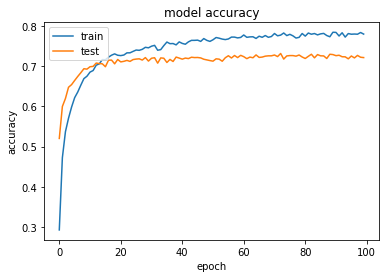

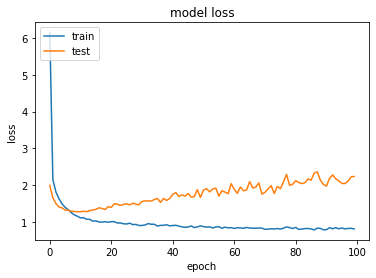

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

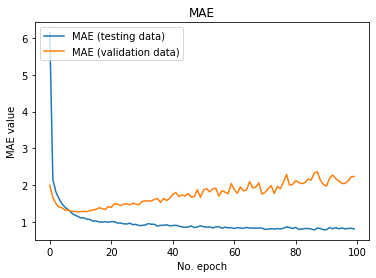

In [30]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

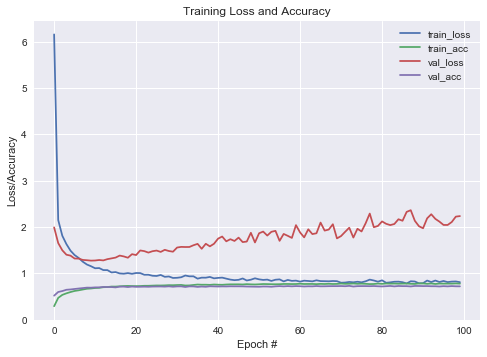

In [31]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()